In [ ]:
import os 
import pandas as pd
from tqdm.notebook import tqdm
import time
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.dates as mdates
from collections import Counter
import collections
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import warnings
import seaborn as sns
from nltk.util import ngrams
from scipy.stats import norm
warnings.filterwarnings("ignore")


In [2]:
os.chdir('./ddps')
data=pd.read_pickle("data_transformed_cleaned.pkl")

In [3]:
data['timestamp_converted']=pd.to_datetime(data.timestamp_converted, errors='coerce')

**sequence analysis**

In [4]:
# for people who are on two or more platfomrs 
user_df=data.drop_duplicates(["user_id", "platform"]).groupby("user_id").size().reset_index()
user_ids=user_df[user_df[0]>1].user_id.to_list()

In [6]:
data_ps=data[data.user_id.isin(user_ids)].sort_values(by=['user_id', 'platform', 'timestamp_converted'])

In [7]:
#some filtered activities 
df_filter1=[
 'likes_and_follows',
 'posts',
 'reactions',
 'last_seen_content',
 'searches',
 'search_history',
 'saved_posts',
 'comment_history',
 'shared_links',
 'likes',
 'favorite_videos_effects_hashtags_sounds',
 'shared_videos',
 'search_history',
 'watched_videos',
 'search_history',
 'watch_history']

In [7]:
data_1=data.reset_index(drop=True)
data_1["activity_type"]=data_1["platform"]+"_"+ data_1["activity_type"]

In [9]:
def process_user_data(df):
    processed = []
    for index, row in df.iterrows():
        if processed:
            last_activity = processed[-1]
            # the time difference
            time_diff = (row['timestamp_converted'] - last_activity['timestamp_converted']).total_seconds() / 60
            # Check if within the same 10-minute block and same activity type
            if time_diff <= 10 and last_activity['activity_type'] == row['activity_type']:
                # Extend the current activity duration, merge details if necessary
                last_activity['timestamp_converted'] = row['timestamp_converted']
                last_activity['details'] = row['details']  # Adjust according to how you want to merge details
            else:
                # append the current row to results if different type or past 10 mins
                processed.append(row.to_dict())
        else:
            # if empty, just add the first row
            processed.append(row.to_dict())

    return pd.DataFrame(processed)

# Apply function to each group
grouped = data_1.sort_values(by=['timestamp_converted']).groupby(['user_id'])
processed_data = pd.concat([process_user_data(group) for _, group in grouped])

In [10]:
df2=processed_data.copy()

**behavior motifs**
- For methodological details, see [Keegan, B. C., Lev, S., & Arazy, O. (2016). *Analyzing organizational routines in online knowledge collaborations: A case for sequence analysis in CSCW*](https://dl.acm.org/doi/abs/10.1145/2818048.2819962?casa_token=FPUrCusLpxYAAAAA:D_k_-ov1vKQs-HUm-50A18veg8nhbnzXqgnX2tno7_TZPwSM9l7t0Ecxioi2_dJNIZCvWrV74yFl6Q). In *Proceedings of the 19th ACM Conference on Computer-Supported Cooperative Work & Social Computing* (pp. 1065-1079).

In [11]:

### baseline for comparison
label_counts = df2['activity_type'].value_counts()
total_labels = label_counts.sum()
label_frequencies = label_counts / total_labels

In [12]:
def get_ngrams(data, n):
    sequences = data.groupby('user_id')['activity_type'].apply(list)
    ngrams_list = sequences.apply(lambda x: list(ngrams(x, n)) if len(x) >= n else [])
    all_ngrams = [item for sublist in ngrams_list for item in sublist]
    return pd.Series(all_ngrams).value_counts()

bigrams = get_ngrams(df2, 2)
trigrams = get_ngrams(df2, 3)
fourgrams = get_ngrams(df2, 4)

In [13]:
def calculate_expected(ngram_counts, label_frequencies, total_ngrams):
    results = {}
    for ngram, count in ngram_counts.items():
        # Calculate expected frequency as a product of the probabilities
        expected_prob = np.prod([label_frequencies.get(label, 0) for label in ngram])
        expected_freq = expected_prob * total_ngrams

        # Convert count to percentage
        observed_percentage = (count / total_ngrams) * 100 
        expected_percentage = expected_prob * 100  # convert expected probability to percentage
        std_dev = np.sqrt(expected_prob * (1 - expected_prob) / total_ngrams) * 100

        # Calculate Z-score
        if std_dev > 0:
            z_score = (observed_percentage - expected_percentage) / std_dev
            p_value = scipy.stats.norm.sf(abs(z_score))*2  # two-sided p-value
            # Apply Bonferroni correction
            alpha = 0.001
            num_tests = len(ngram_counts)
            bonferroni_alpha = alpha / num_tests

            if p_value < bonferroni_alpha:
                results[ngram] = {
                    'Observed %': "{:.2f}% ({:.2f}%)".format(observed_percentage, expected_percentage),
                    'Expected %': "{:.2f}%".format(expected_percentage),
                    'Z-score': z_score,
                    'p-value': "{:.5f}".format(p_value)
                }
    return results


In [14]:
bigram_results = calculate_expected(bigrams, label_frequencies, total_labels)
trigram_results = calculate_expected(trigrams, label_frequencies, total_labels)
fourgram_results = calculate_expected(fourgrams, label_frequencies, total_labels)

In [15]:
bigram_results

{('youtube_watch_history',
  'youtube_watch_history'): {'Observed %': '13.27% (3.02%)', 'Expected %': '3.02%', 'Z-score': 306.28873795895765, 'p-value': '0.00000'},
 ('tiktok_login_history',
  'tiktok_watched_videos'): {'Observed %': '10.47% (2.21%)', 'Expected %': '2.21%', 'Z-score': 286.8360695155938, 'p-value': '0.00000'},
 ('tiktok_watched_videos',
  'tiktok_login_history'): {'Observed %': '9.06% (2.21%)', 'Expected %': '2.21%', 'Z-score': 237.96623487134778, 'p-value': '0.00000'},
 ('instagram_likes', 'instagram_likes'): {'Observed %': '5.55% (1.72%)',
  'Expected %': '1.72%',
  'Z-score': 151.00591095150716,
  'p-value': '0.00000'},
 ('instagram_likes', 'instagram_shared_links'): {'Observed %': '3.63% (1.04%)',
  'Expected %': '1.04%',
  'Z-score': 130.64413144046796,
  'p-value': '0.00000'},
 ('instagram_shared_links', 'instagram_likes'): {'Observed %': '3.62% (1.04%)',
  'Expected %': '1.04%',
  'Z-score': 129.81498064241026,
  'p-value': '0.00000'},
 ('tiktok_watched_videos',


**data preparation for sequence visualization and clustering using [TraMineR](https://traminer.unige.ch/)**

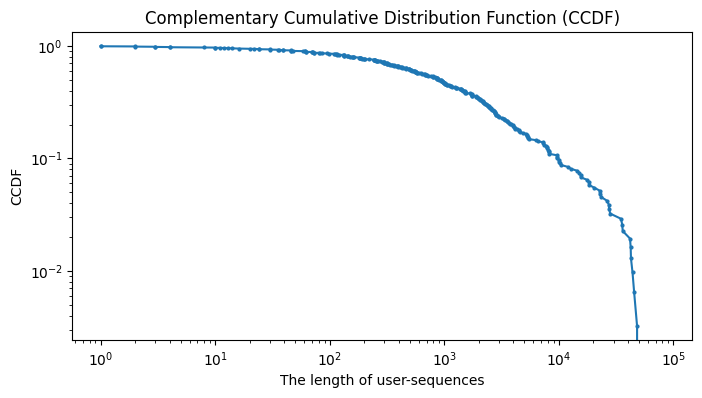

In [135]:
## sequence length distribution 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  
ccdf = 1. -np.arange(1, len(count)+1) / len(count)

plt.plot(count, ccdf, marker='o', linestyle='-', markersize=2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('The length of user-sequences')
plt.ylabel('CCDF')
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.grid(False)
plt.show()


In [7]:
df3 = data_1.groupby('user_id')['activity_type'].apply(list).reset_index()

In [8]:
# for the states in traminer 
data_1['activity_type'].unique()

array(['instagram_likes', 'tiktok_watched_videos', 'facebook_searches',
       'youtube_search_history', 'youtube_watch_history',
       'facebook_reactions', 'tiktok_search_history',
       'instagram_shared_links', 'instagram_saved_posts',
       'instagram_comment_history', 'facebook_posts',
       'tiktok_shared_videos',
       'tiktok_favorite_videos_effects_hashtags_sounds',
       'facebook_likes_and_follows', 'facebook_last_seen_content',
       'instagram_search_history'], dtype=object)

In [11]:
# half of users 
np.quantile([i for i in df3.length], q=[0.25, 0.75])

array([ 228., 2805.])

In [29]:
## some processing 
df3["length"]=df3.activity_type.apply(len)
df4=df3[df3.length>227][df3.length<2805].reset_index(drop=True)
dfs=[]
for i in df4.user_id.to_list():
    dfs.append(df4[df4.user_id==i].reset_index(drop=True))

In [294]:
## switch to traminer 
df_new=pd.concat(dfs).reset_index()
df_new.to_csv("sample_for_traminer1.csv", index=False)

In [12]:
# get the OM results back from traminer
dist_matrix=pd.read_csv("file.csv", sep=",", header = None)

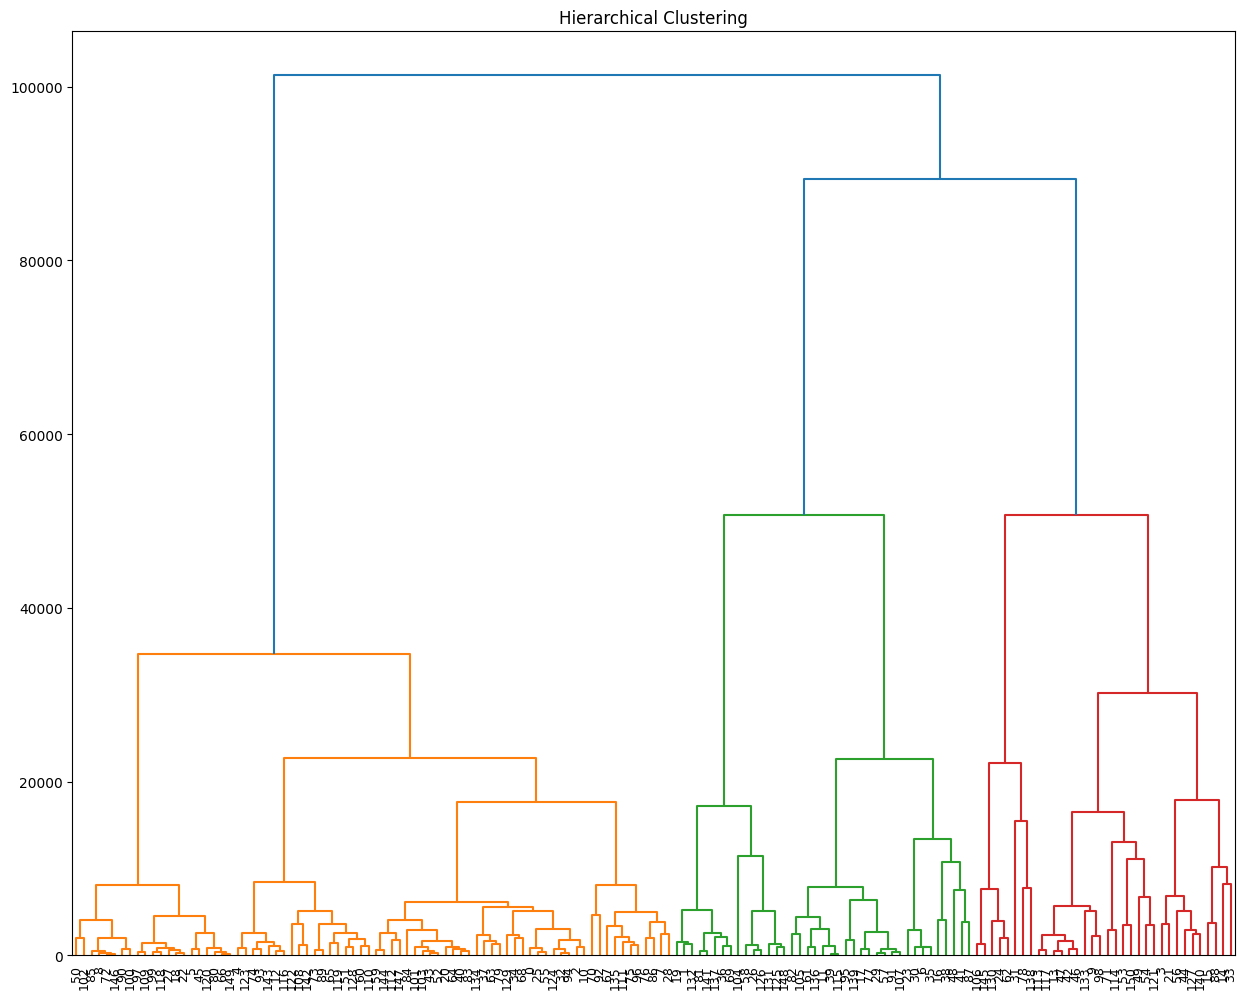

In [16]:
# cluster the dist matrix 
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch

fig, ax= plt.subplots(1,1, figsize=(15,12))
# Hierarchical clustering
linkage_matrix = linkage(dist_matrix.values, 'ward')
dendrogram(linkage_matrix, labels=list(range(151)))
plt.title('Hierarchical Clustering')
plt.tick_params(axis='x', which='major', labelsize=9, )
plt.show()


In [80]:
clusters=sch.fcluster(linkage_matrix, t=10000, criterion='distance')

In [81]:
clusters

array([ 3,  5,  3, 19,  2,  1,  9,  4,  1, 15,  3,  8,  2, 15, 21, 20, 10,
        8,  1,  5,  3, 19,  1,  9, 12,  3,  6,  1,  4,  8,  9, 14,  3, 21,
        3,  9,  5,  3, 10,  8,  3, 11, 15,  3, 19,  1, 15, 15, 11, 18,  1,
        2,  3, 17, 18,  3, 19,  8,  6,  3,  2,  8, 12,  3,  3,  2,  1,  4,
        3,  5,  4, 16,  1,  2,  2,  4,  4,  8, 13,  3,  1,  5,  8,  3,  3,
        1,  4, 11, 20,  2,  1,  8,  4,  2,  3,  8,  4,  1, 15,  1,  1,  3,
        1,  3,  7,  8, 12,  8,  2,  1,  2,  4,  3, 15, 16,  8,  2, 15,  1,
        2,  1, 18,  2,  2,  3,  6,  6, 19,  2,  3, 12,  6,  5, 15,  3,  4,
        8,  5, 13,  8, 19,  5,  2,  2,  3, 12,  1,  3,  6,  1, 17],
      dtype=int32)

In [102]:
# giving back to traminer to visualize
cluster1=[eval(i) for i in df4[df4.clusters==10].user_id.unique()]
df_c1=df_new[df_new.user_id.isin(cluster1)]
#df_new=pd.concat(dfs).reset_index()
df_c1.columns=['turn', 'user_id', 'activity_type', 'length']
df_c1.to_csv("cluster10y.csv", index=False)

In [83]:
df4['clusters']=clusters